## Some imports

In [1]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io
import util
import os

In [2]:
def dist(f1, f2):
    """
    distance between two frames assuming they are optimally aligned
    :param f1: frame 1
    :param f2: frame 2
    :return: the distance
    """
    return np.sum(np.power((f1 - f2).reshape((-1, 1)), 2))

In [3]:
f_orig_data = '../149septinpixels.mat'
f_rotated_data = '../149septin_rotated.npy'
f_distances = '../149septin_distances.npy'

## Load, center, rotate, pad and save data

In [4]:
frames_padded = []

if not os.path.isfile(f_rotated_data):
    raw_dat = scipy.io.loadmat(f_orig_data)

    dat = raw_dat["allseptins"]
    lxmax = None
    lymax = None
    n_frames = dat.size
    for i in range(n_frames):
        frame_dat = dat[0][i]
        lx, ly = frame_dat.shape
        lxmax = max(lx, lxmax) if lxmax is not None else lx
        lymax = max(ly, lymax) if lymax is not None else ly

    lmax = max(lxmax, lymax) * 1.5

    for i in range(n_frames):
        frame_dat = dat[0][i]

        lx, ly = frame_dat.shape
        cx, cy = util.frame_COM(frame_dat)

        offset_x = int(np.rint(0.5 * lx - cx))
        offset_y = int(np.rint(0.5 * ly - cy))

        frame_dat = np.roll(frame_dat, offset_x, axis=0)
        frame_dat = np.roll(frame_dat, offset_y, axis=1)

        th = util.frame_orient(frame_dat)

        frame_dat_padded = np.zeros([lmax, lmax], dtype=np.float32)
        util.insert_rot_frame(frame_dat, frame_dat_padded, th)
        frames_padded.append(frame_dat_padded)

    np.save(f_rotated_data, frames_padded)
else:
    frames_padded = np.load(f_rotated_data)

if not os.path.isfile(f_distances):
    d = np.zeros((n_frames, n_frames), dtype=np.float32)
    for i in range(n_frames):
        for j in range(i + 1, n_frames):
            d[i, j] = dist(frames_padded[i], frames_padded[j])
            d[j, i] = d[i, j]
    np.save(f_distances, d)
else:
    d = np.load(f_distances)


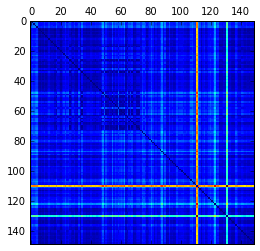

In [5]:
plt.matshow(d)

In [6]:
print d.shape

(149, 149)


In [7]:
from sklearn.decomposition import KernelPCA

pca = KernelPCA()
res = pca.fit_transform(np.dot(d, d.T))

In [8]:
# todo: apply http://sebastianraschka.com/Articles/2014_kernel_pca.html 
# or http://www.stat.washington.edu/courses/stat539/spring14/Resources/tutorial_nonlin-dim-red.pdf